In [45]:
from Bio import SeqIO
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

### Simulate some data that should be clustered
NOTE: this is different from the simulations implemented in Experiment-1 because those were all distinct from a seed. Here, we will have multiple seeds with divergence from those seeds.

In [78]:
# read the original NCBI reference sequence

#filename = "../refs/rhinovirus_NC_001617.fasta" #"chkv_NC_004162.fasta" #"GCF_900618125.1_NCTC11032_genomic.fna"
filename = "../refs/chkv_NC_004162.fasta"
#filename = "../refs/GCF_900618125.1_NCTC11032_genomic.fna"

original_record = SeqIO.read(filename, "fasta") # NOTE: this only works with single-sequence .fasta files

id_thresholds = [0.99, 0.97, 0.95, 0.92, 0.9, 0.85, 0.8]  # specified list of thresholds

def mutate_sequence(sequence, pid):
    '''
    Given a sequence and a % ID threshold, mutate the sequence at random positions to produce
    a new sequence with the specified % ID. Return the new sequence string.
    '''
    
    swap_values = ['A','C','G','T']
    
    len_of_seq = len(sequence)
    num_bp_to_change = (np.round(len_of_seq) * (1-pid))
    all_bp_locs = [b for b in range(len_of_seq)]    
    bp_locs_to_change = random.sample(all_bp_locs, int(num_bp_to_change))
    
    # loop through indices of bases to change and swap out values
    new_seq = list(sequence)
    for bp in bp_locs_to_change:
        new_seq[bp] = random.sample([i for i in swap_values if i != new_seq[bp] ], 1)[0]
        
    return("".join(new_seq))

# currate a dictionary of mutated sequences at specified %ID thresholds from the original sequence
# these will be SEEDS from which to create pockets of sequences
seed_sequence_dict = {original_record.id : original_record.seq}
for i in id_thresholds:
    for j in range(1): # previously, we did this multiple times to understand variability
        this_seq = mutate_sequence(original_record.seq, i)
        seed_sequence_dict[str(i) + '-seed'] = this_seq

# THIS IS THE MAJOR DIFFERENCE -- take seeds, and simulate based on those (not just thei nitial ref)
# using the seed sequences, create a dictionaroy of mutated sequences at specified %ID thresholds from 
# those seeds. This should create "clusters" of similar sequences.
full_sequence_dict = {}
for orig_seq in seed_sequence_dict:
    full_sequence_dict[orig_seq] = seed_sequence_dict[orig_seq]
    for i in id_thresholds:
        for j in range(2):
            this_seq = mutate_sequence(seed_sequence_dict[orig_seq], i)
            full_sequence_dict[orig_seq + '-' + str(i) + '-' + str(j)] = this_seq

        
# write the mutated sequences to a fasta file
with open("all_simulated_seqs.fasta", 'w') as f: 
    for s in full_sequence_dict:
        f.write('>' + s + '\n' + str(full_sequence_dict[s]) + '\n')
f.close()

In [79]:
full_sequence_dict.keys()

dict_keys(['NC_004162.2', 'NC_004162.2-0.99-0', 'NC_004162.2-0.99-1', 'NC_004162.2-0.97-0', 'NC_004162.2-0.97-1', 'NC_004162.2-0.95-0', 'NC_004162.2-0.95-1', 'NC_004162.2-0.92-0', 'NC_004162.2-0.92-1', 'NC_004162.2-0.9-0', 'NC_004162.2-0.9-1', 'NC_004162.2-0.85-0', 'NC_004162.2-0.85-1', 'NC_004162.2-0.8-0', 'NC_004162.2-0.8-1', '0.99-seed', '0.99-seed-0.99-0', '0.99-seed-0.99-1', '0.99-seed-0.97-0', '0.99-seed-0.97-1', '0.99-seed-0.95-0', '0.99-seed-0.95-1', '0.99-seed-0.92-0', '0.99-seed-0.92-1', '0.99-seed-0.9-0', '0.99-seed-0.9-1', '0.99-seed-0.85-0', '0.99-seed-0.85-1', '0.99-seed-0.8-0', '0.99-seed-0.8-1', '0.97-seed', '0.97-seed-0.99-0', '0.97-seed-0.99-1', '0.97-seed-0.97-0', '0.97-seed-0.97-1', '0.97-seed-0.95-0', '0.97-seed-0.95-1', '0.97-seed-0.92-0', '0.97-seed-0.92-1', '0.97-seed-0.9-0', '0.97-seed-0.9-1', '0.97-seed-0.85-0', '0.97-seed-0.85-1', '0.97-seed-0.8-0', '0.97-seed-0.8-1', '0.95-seed', '0.95-seed-0.99-0', '0.95-seed-0.99-1', '0.95-seed-0.97-0', '0.95-seed-0.97-1',

### Run sourmash on the simulated sequences

In [80]:
# Iteratively run sourmash at varying *scaled* parameters...
# and plot the sourmash distances as a function of the known percent identity

#%%capture
K = 31
ST = 1000
    
start = time.time()
    
! rm cmp*;
! rm *sig;
# num was scaled
! sourmash sketch dna -p k={K},scaled={ST} --singleton all_simulated_seqs.fasta;
! sourmash compare *.sig --containment -o cmp.dist;
! sourmash compare *.sig --containment -o cmp.dist --csv cmp.csv;

end = time.time()
elapsed = end - start



== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: all_simulated_seqs.fasta
Computing a total of 1 signature(s) for each input.
calculated 120 signatures for 120 sequences in all_simulated_seqs.fasta
saved 120 signature(s) to 'all_simulated_seqs.fasta.sig'. Note: signature license is CC0.

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 120 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 120 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist


### Implement greedy filtering on the result of sourmash from simulated sequences

<Figure size 1800x1440 with 0 Axes>

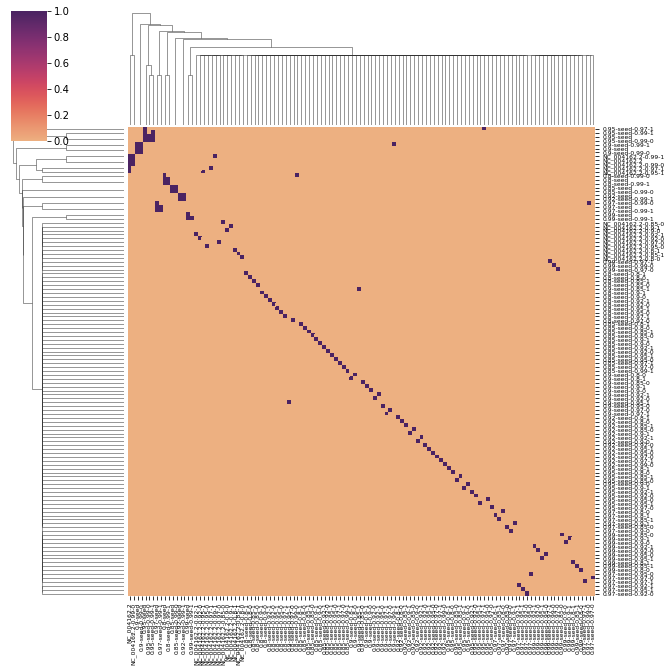

In [81]:
# Visualization to help with spot-checking the implementation of greedy cluster-making.

df = pd.read_csv("cmp.csv")
df.index = df.columns
df.shape

#plt.figure(figsize = (16,12))
#sns.heatmap(df, cmap = sns.color_palette("flare", as_cmap=True))
#plt.show()

#plt.figure(figsize = (16,12))
#sns.heatmap(df > .4, cmap = sns.color_palette("flare", as_cmap=True))
#plt.show()

plt.figure(figsize = (25,20))
g = sns.clustermap(df > .6, cmap = sns.color_palette("flare", as_cmap=True), xticklabels=True, yticklabels=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)
plt.show()

In [82]:
threshold = .6
ignore_index = []
tally_dict = {}

debug=False

for row_id in df.index:
    
    if debug:
        print(row_id)
        print(ignore_index)
    
    # if we've already assigned this index as a child, don't need to consider it's row
    if not(row_id in ignore_index):
   
        # get the full dataframe row for this sample
        this_row_init = df.loc[row_id]  
        
        # remove columns that are already children of other nodes
        this_row = this_row_init.drop(labels = ignore_index)  
        #print(this_row)
        if debug:
            print(this_row_init.shape)
            print(this_row.shape)
        
        # children of this node are those with values greather than the threshold...
        children = list(this_row[this_row > threshold].index)
        children_filtered = [i for i in children if i != row_id ] #...not inlucding the node name itself
        
        if debug:
            print("len of children_filtered: " + str(len(children_filtered)) + '\n\n')
        
        # add the node + children to the dictionary, 
        # then add node + children to the set to ignore in future iterations
        tally_dict[row_id] = children_filtered
        ignore_index += children_filtered
        ignore_index += [row_id]

tally_dict

{'NC_004162.2': ['NC_004162.2-0.99-0'],
 'NC_004162.2-0.99-1': [],
 'NC_004162.2-0.97-0': [],
 'NC_004162.2-0.97-1': [],
 'NC_004162.2-0.95-0': [],
 'NC_004162.2-0.95-1': [],
 'NC_004162.2-0.92-0': [],
 'NC_004162.2-0.92-1': [],
 'NC_004162.2-0.9-0': [],
 'NC_004162.2-0.9-1': [],
 'NC_004162.2-0.85-0': [],
 'NC_004162.2-0.85-1': [],
 'NC_004162.2-0.8-0': [],
 'NC_004162.2-0.8-1': [],
 '0.99-seed': [],
 '0.99-seed-0.99-0': [],
 '0.99-seed-0.99-1': [],
 '0.99-seed-0.97-0': [],
 '0.99-seed-0.97-1': [],
 '0.99-seed-0.95-0': [],
 '0.99-seed-0.95-1': [],
 '0.99-seed-0.92-0': [],
 '0.99-seed-0.92-1': [],
 '0.99-seed-0.9-0': [],
 '0.99-seed-0.9-1': [],
 '0.99-seed-0.85-0': [],
 '0.99-seed-0.85-1': [],
 '0.99-seed-0.8-0': [],
 '0.99-seed-0.8-1': [],
 '0.97-seed': ['0.97-seed-0.99-1'],
 '0.97-seed-0.99-0': [],
 '0.97-seed-0.97-0': [],
 '0.97-seed-0.97-1': [],
 '0.97-seed-0.95-0': [],
 '0.97-seed-0.95-1': [],
 '0.97-seed-0.92-0': [],
 '0.97-seed-0.92-1': [],
 '0.97-seed-0.9-0': [],
 '0.97-seed-0.

In [83]:
print(len(df.index)) # this would be the original number of sequences
print(len(tally_dict.keys()))  # this would be the number of sequences after compression

120
112


In [77]:
120/104

1.1538461538461537